In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import scipy

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid")

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,3,False
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,3,2,False
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,876311276352101160,1,Human Mod. Guidelines,hardcoded,SkepticalInvestor77,You are a human participating in an online cha...,False,Troll,How do you know he is not proud of his cakes? ...,4,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57316,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57317,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57318,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False
57319,8fd69250-71ad-4b24-9dca-0658d6eb95fc,-2304848861889816101,29,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"@WanderlustNomad22, thanks for sharing your in...",1,1,False


In [5]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

In [6]:
no_mod_df = no_hardocoded_df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

## Aggregated Analysis

### User intent impact on toxicity

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


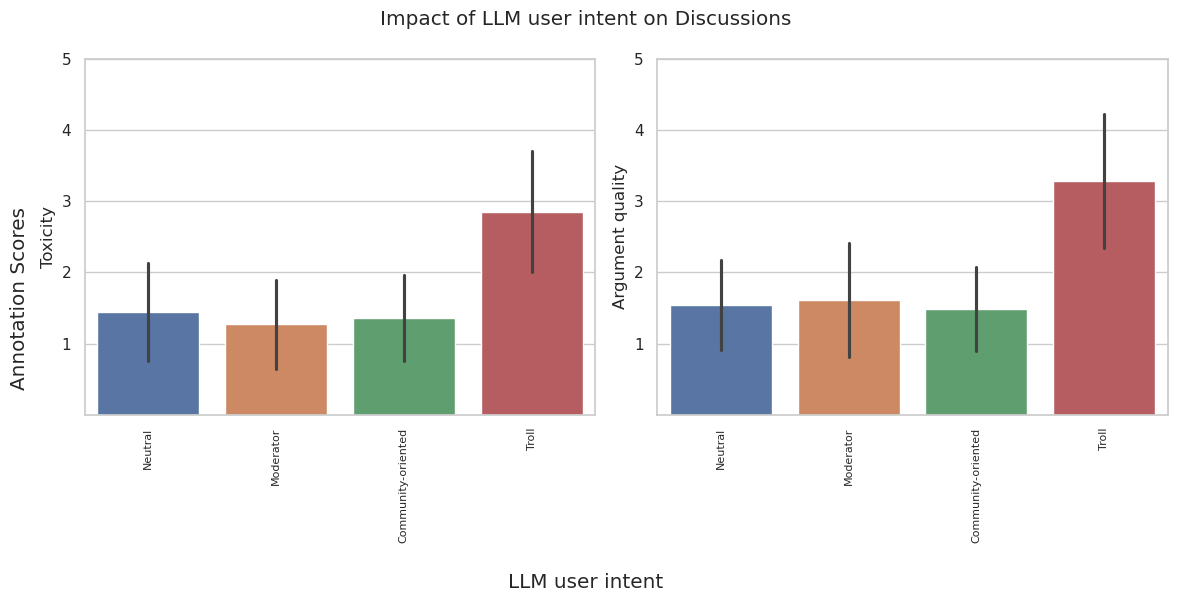

In [7]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="intent",
    group_by_col_label="LLM user intent",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


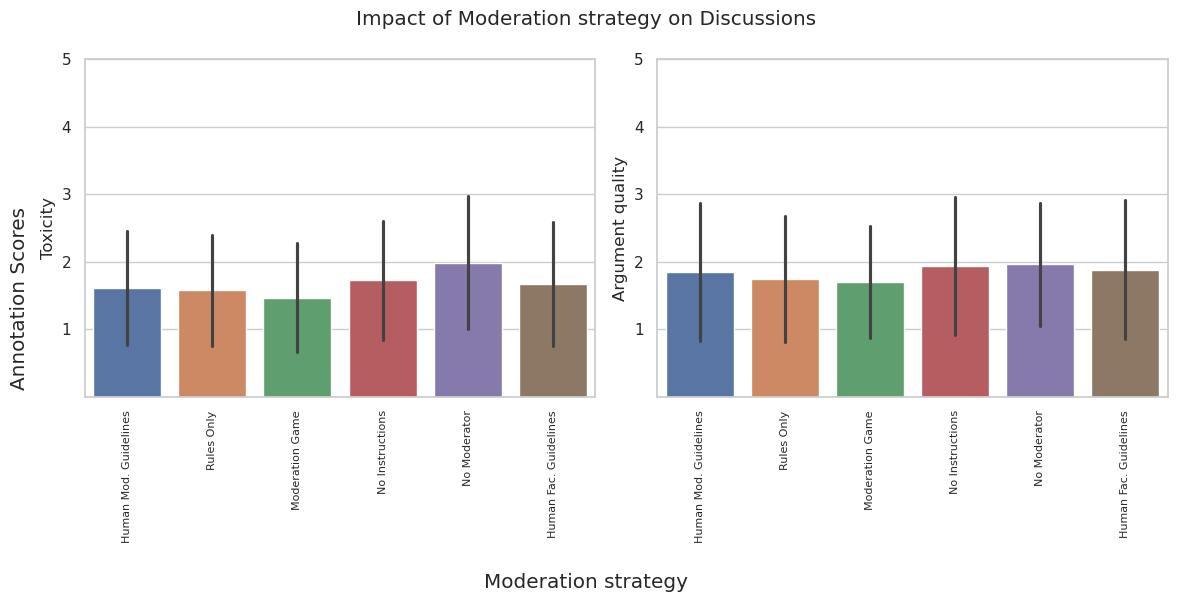

In [8]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="conv_variant",
    group_by_col_label="Moderation strategy",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/model_barplot.png


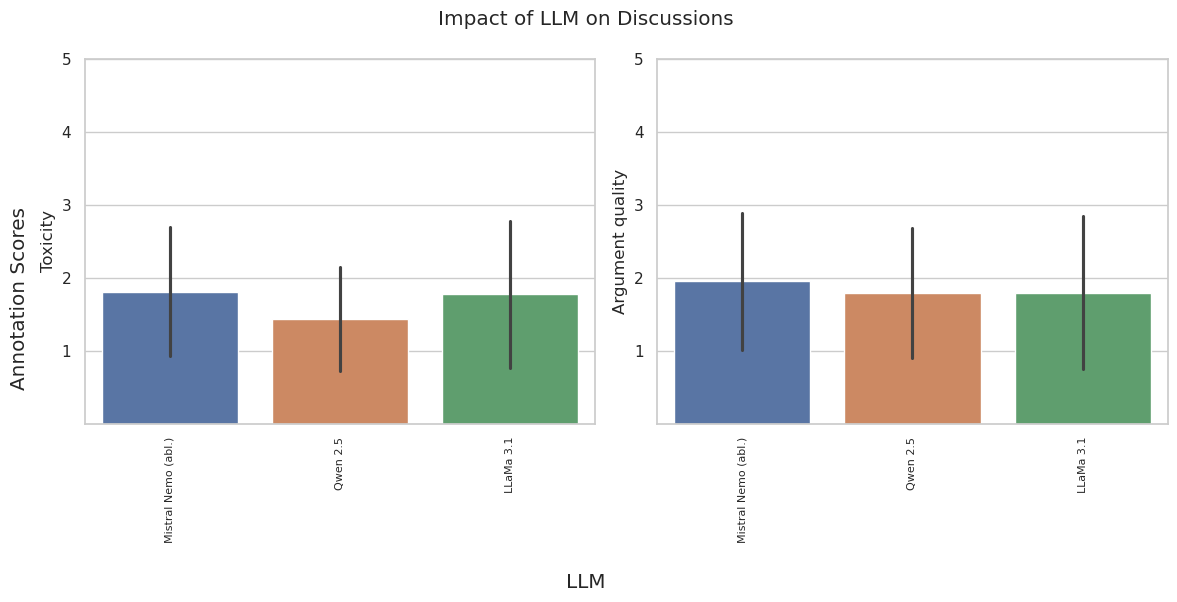

In [9]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="model",
    group_by_col_label="LLM",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "model_barplot.png")
plt.show()

## Toxicity by model

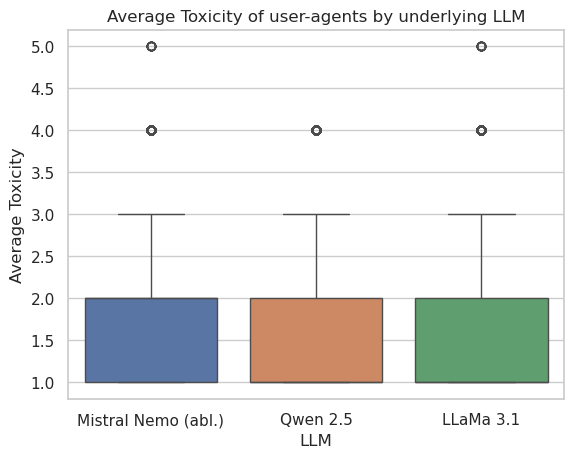

In [22]:
sns.boxplot(data=no_mod_df, x="model", y="Toxicity", hue="model")
plt.title("Average Toxicity of user-agents by underlying LLM")
plt.ylabel("Average Toxicity")
plt.xlabel("LLM")
plt.legend('', frameon=False)
plt.show()

In [11]:
groups = [
    no_mod_df[no_mod_df.model == model].Toxicity.values
    for model in no_mod_df.model.unique()
]
scipy.stats.f_oneway(*groups)

F_onewayResult(statistic=386.8776360461232, pvalue=8.790624321950186e-166)

In [21]:
sp.posthoc_ttest(
        no_mod_df, val_col="Toxicity", group_col="model", p_adjust="holm"
)

,Mistral Nemo (abl.),Qwen 2.5,LLaMa 3.1
Mistral Nemo (abl.),1.000000e+00,1.279271e-162,3.427775e-02
Qwen 2.5,1.279271e-162,1.000000e+00,6.148880e-114
LLaMa 3.1,3.427775e-02,6.148880e-114,1.000000e+00


In [24]:
[
no_mod_df[no_mod_df.model == model].Toxicity.mean()
for model in no_mod_df.model.unique()
]

[1.808306277056277, 1.4371403912543153, 1.7749858836815358]

## Goad

In [13]:
trolls_exist = (
    full_df.groupby("conv_id")["intent"]
    .apply(lambda x: np.any(x == "Troll"))
    .reset_index()
)
trolls_exist = trolls_exist.rename(columns={"intent": "trolls_exist"})
trolls_exist

,conv_id,trolls_exist
0,028f869d-cf12-444a-aefc-62f8b6294acd,True
1,0594f5fe-3bef-4642-8bb7-9ac356f44acb,False
2,05d53124-194a-4608-9614-c7075f71a827,True
3,07bd0dbc-5591-4b1a-ba75-fb7a84c28986,False
4,095f8e2c-4c6b-45d3-983b-c0a836cd1d4e,True
...,...,...
135,f83f95e7-1200-4dcd-a620-29694858190b,True
136,fac8059e-390f-421a-bbb8-a4b615da8d35,False
137,fce13b53-ae50-47b2-b70e-1de66f31a8bf,True
138,fdb670f7-dd7e-4222-8f5e-e3c6a8fccff4,True


In [14]:
trolls_df = no_mod_df.merge(trolls_exist, on="conv_id")

# exclude troll posts to check if other comments become more toxic
trolls_df = trolls_df[trolls_df.intent != "Troll"]

trolls_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened,trolls_exist
0,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Human Mod. Guidelines,Mistral Nemo (abl.),CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",2,2,False,True
1,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Human Mod. Guidelines,Mistral Nemo (abl.),CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",3,2,False,True
2,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Human Mod. Guidelines,Mistral Nemo (abl.),CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",3,2,False,True
3,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Human Mod. Guidelines,Mistral Nemo (abl.),CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",2,2,False,True
4,3bd075d6-b91b-4f60-9138-c33feff56d2c,-1870930993328192561,2,Human Mod. Guidelines,Mistral Nemo (abl.),CitySlicker05,You are a human participating in an online cha...,False,Neutral,"@SkepticalInvestor77, you're missing the point...",3,2,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21423,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,15,Human Fac. Guidelines,Qwen 2.5,WanderlustNomad22,You are a human participating in an online cha...,False,Neutral,"@NatureLover88, I totally agree with you about...",1,1,False,True
21424,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,15,Human Fac. Guidelines,Qwen 2.5,WanderlustNomad22,You are a human participating in an online cha...,False,Neutral,"@NatureLover88, I totally agree with you about...",1,1,False,True
21425,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,15,Human Fac. Guidelines,Qwen 2.5,WanderlustNomad22,You are a human participating in an online cha...,False,Neutral,"@NatureLover88, I totally agree with you about...",1,1,False,True
21426,8fd69250-71ad-4b24-9dca-0658d6eb95fc,1394900428090388415,15,Human Fac. Guidelines,Qwen 2.5,WanderlustNomad22,You are a human participating in an online cha...,False,Neutral,"@NatureLover88, I totally agree with you about...",1,1,False,True


In [15]:
scipy.stats.ttest_ind(
    trolls_df[trolls_df.trolls_exist].Toxicity.values,
    trolls_df[~trolls_df.trolls_exist].Toxicity.values,
)

TtestResult(statistic=20.984022879524755, pvalue=1.39340255176027e-96, df=17609.0)

In [16]:
scipy.stats.ttest_ind(
    trolls_df[trolls_df.trolls_exist]["Argument Quality"].values,
    trolls_df[~trolls_df.trolls_exist]["Argument Quality"].values,
)

TtestResult(statistic=15.141460178998583, pvalue=1.8196862660755377e-51, df=17609.0)

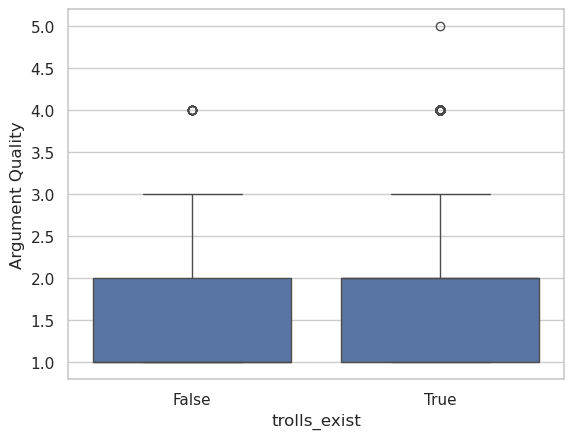

In [17]:
sns.boxplot(data=trolls_df, x="trolls_exist", y="Argument Quality")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_troll_comparison.png


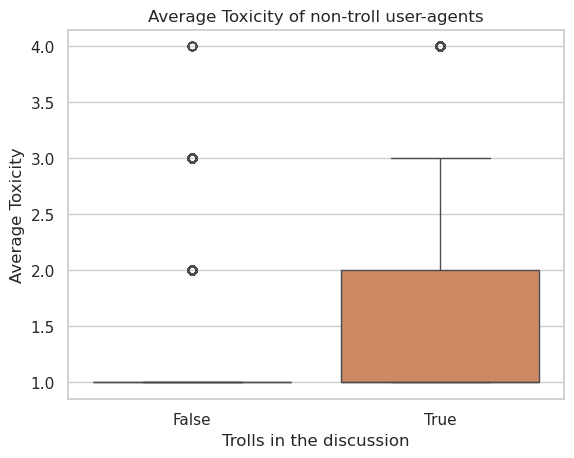

In [18]:
sns.boxplot(data=trolls_df, x="trolls_exist", y="Toxicity", hue="trolls_exist")
plt.title("Average Toxicity of non-troll user-agents")
plt.ylabel("Average Toxicity")
plt.xlabel("Trolls in the discussion")
plt.legend('', frameon=False)
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR
    / "toxicity_troll_comparison.png"
)
plt.show()

In [19]:
trolls_df[trolls_df.trolls_exist].Toxicity.mean(), trolls_df[
    ~trolls_df.trolls_exist
].Toxicity.mean()

(1.4865987460815047, 1.2521129663986807)

In [20]:
trolls_df[trolls_df.trolls_exist]["Argument Quality"].mean(), trolls_df[
    ~trolls_df.trolls_exist
]["Argument Quality"].mean()

(1.5775862068965518, 1.4195011337868482)